In [7]:
# Imports
import torch
cuda = torch.cuda.is_available()
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sys
sys.path.append("../../semi-supervised")

# Variational Autoencoder

The variational autoencoder (VAE) was described in its current form in [Kingma 2013](https://arxiv.org/abs/1312.6114). The model consists of an encoder/inference network $q_{\phi}(z|x)$ and a decoder/generative network $p_{\theta}(x|z)$. The main idea is that it is possible to both reconstruct and generate samples from from some input distribution by learning a variational distribution over the latent variable $z$.

<img src="../images/vae.png" width="300px"/>

The VAE therefore has a bottleneck structure, where the input $x$ is encoded into a latent variable $z$. New data can then be generated by feeding a latent code into the generator network - $\widehat{x} \sim p_{\theta}(z|x)$. The diagram above shows the generative model (right) and how the latent variable $z$ is inferred from $x$ (left).

Below we will instantiate a new variational autoencoder with this bottleneck structure consisting of a 2-layer encoder network turning an input MNIST image into a latent code: $784 \to 256 \to 128 \to 32$. We also have a decoder that performs the operation in reverse: $32 \to 128 \to 256 \to 784$.

In [8]:
from models import VariationalAutoencoder
from layers import GaussianSample
model = VariationalAutoencoder([784, 32, [256, 128]])
model

VariationalAutoencoder(
  (encoder): Encoder(
    (hidden): ModuleList(
      (0): Linear(in_features=784, out_features=256, bias=True)
      (1): Linear(in_features=256, out_features=128, bias=True)
    )
    (sample): GaussianSample(
      (mu): Linear(in_features=128, out_features=32, bias=True)
      (log_var): Linear(in_features=128, out_features=32, bias=True)
    )
  )
  (decoder): Decoder(
    (hidden): ModuleList(
      (0): Linear(in_features=32, out_features=128, bias=True)
      (1): Linear(in_features=128, out_features=256, bias=True)
    )
    (reconstruction): Linear(in_features=256, out_features=784, bias=True)
    (output_activation): Sigmoid()
  )
)

Notice how the middle most layer consists of a `GaussianSample` layer, in which we turn the input digit into the parameters of a Normal distribution with parameters $\mu$ and $\sigma$. This allows us to use the *reparametrization trick* to sample from this distribution to introduce stochasticity into the network.

In [9]:
from torch.autograd import Variable

gaussian = GaussianSample(10, 1)
z, mu, log_var = gaussian(Variable(torch.ones(1, 10)))

print(f"sample {float(z.data):.2f} drawn from N({float(mu.data):.2f}, {float(log_var.exp().data):.2f})")

sample -2.55 drawn from N(0.83, 3.28)


## Training

How do we go about training a variational autoencoder then? We want to model the data distribution $p(x)$, from here we can introduce a variational distribution $q(z|x)$ by multiplying and dividing by this distribution. Now we employ Jensen's inequality to move the logarithm inside the integral, we can do this because $\log$ is concave and because $q(z|x)$ is a probability distribution. From here on we just rearrange and we see that a lower bound on the marginal probability of the data $p(x)$ is just an expectation over the likelihood of the data minus the KL-divergence between the variational distribution and a prior $p(z)$.

\begin{align}
\log p(x) &= \log \int p(x, z) \ dz = \log \int q(z|x) \frac{p(x, z)}{q(z|x)} \ dz\\
          &\geq \int q(z|x) \log \frac{p(x, z)}{q(z|x)} \ dz = \int q(z|x) \log p(x|z) + \log \frac{p(z)}{q(z|x)} \ dz\\
          &= \int q(z|x) \log p(x|z) \ dz + \int q(z|x) \log \frac{p(z)}{q(z|x)} \ dz\\
          &= \mathbb{E}_{q(z|x)} [\log p(x|z)] - KL(q(z|x)||p(z)) = \mathcal{L}(x)
\end{align}

To make things even more concrete, we show how we can go from this equation to an actual algorithm. Recall that the expectation is just an arithmetic mean, which can be approximated using Monte-Carlo samples. In fact for most applications we can do with just a single sample, even though this provides infinite variance.

$$\mathbb{E}_{q(z|x)} [\log p(x|z)] = \lim_{N \to \infty} \frac{1}{N} \sum_{i=1}^{N} \log p(x_i|z_i) \approx \frac{1}{M} \sum_{i=1}^{M} \log p(x_i|z_i)$$

As you can see the likelihood is just the log probability of the data given the latent variable, but the latent variable is itself derived from the data - we can just use the reconstruction error! In the MNIST case, it is most fitting to use the Bernoulli / binary cross entropy.

Finally, the second term is the Kullback-Leibler divergence. It states that whatever distribution we learn over $q(z|x)$ can never be very far from the prior $p(z)$. This is both good and bad news. Ideally we want a reconstruction that is as good as possible, i.e. only relying on the likelihood, which will only occur if $q(z|x) = p(z)$. This will never happen in practice as the q-distribution will be very complex in order to produce latent variables that result convincing samples. On the plus side, the KL-term acts as a regularizer that pulls the distribution towards the prior, which is the whole reason why we can create samples.

This term can either be computed analytically, or by sampling similarly to the way we did it in the expectation, which you can see in the printed doc string below.

In [10]:
print(model._kld.__doc__)


        Computes the KL-divergence of
        some element z.

        KL(q||p) = -∫ q(z) log [ p(z) / q(z) ]
                 = -E[log p(z) - log q(z)]

        :param z: sample from q-distribuion
        :param q_param: (mu, log_var) of the q-distribution
        :param p_param: (mu, log_var) of the p-distribution
        :return: KL(q||p)
        


In [11]:
from datautils import get_mnist

_, train, validation = get_mnist(location="./", batch_size=64)

# We use this custom BCE function until PyTorch implements reduce=False
def binary_cross_entropy(r, x):
    return -torch.sum(x * torch.log(r + 1e-8) + (1 - x) * torch.log(1 - r + 1e-8), dim=-1)

optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, betas=(0.9, 0.999))

In [14]:
for epoch in range(50):
    model.train()
    total_loss = 0
    for (u, _) in train:
        u = Variable(u)

        # if cuda: u = u.cuda(device=0)

        reconstruction = model(u)
        
        likelihood = -binary_cross_entropy(reconstruction, u)
        elbo = likelihood - model.kl_divergence
        
        L = -torch.mean(elbo)

        L.backward()
        optimizer.step()
        optimizer.zero_grad()

        total_loss += L.data.item()

    m = len(train)

    if epoch % 10 == 0:
        print(f"Epoch: {epoch}\tL: {total_loss/m:.2f}")

Epoch: 0	L: 191.51
Epoch: 10	L: 134.66
Epoch: 20	L: 130.70
Epoch: 30	L: 128.90
Epoch: 40	L: 127.77


In [15]:
torch.save(model, "my-pretrained-vae.pt")

## Sampling from the generative model

Now that we have trained the network, we can begin to sample from it. We simply give it some random noise distributed according to the prior $p(z) = \mathcal{N}(0, I)$ and send it through the decoder. This process generates a slew of samples that look like they come from the original distribution $p(x)$.

In [16]:
model.eval()
x_mu = model.sample(Variable(torch.randn(16, 32)))

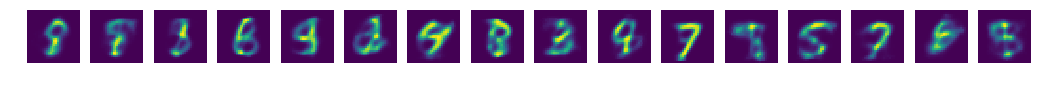

In [17]:
f, axarr = plt.subplots(1, 16, figsize=(18, 12))

samples = x_mu.data.view(-1, 28, 28).numpy()

for i, ax in enumerate(axarr.flat):
    ax.imshow(samples[i])
    ax.axis("off")

## Side note: Normalizing flows

We can get a more expressive variational approximation by using flows. In the regular variational autoencoder we are limited to a diagonal Gaussian distribution as the output of our encoder, but we can do better. Introducing a full-rank covariance matrix would be an option, but we will quickly see that it becomes computationally infeasible.

What we instead can do is to use change-of-variables to calculate the probability of a random sample under some transformation. In fact, if this transformation is made in a specific way, it is simple to calculate the probability of a sample under a series of $K$ transforms.

$$\ln q_K(z_K) = \ln q_0(z_0) − \sum_{k=1}^{K} \ln \bigg | \det \frac{\partial f_k}{\partial z_{k-1}} \bigg |$$

This is the essence of [Normalizing Flows (Rezende & Mohammed, 2015)](https://arxiv.org/abs/1505.05770). This process increases the expressability of the variational distribution and will likely give a better estimate of the marginal likelihood of the data $p(x)$. However, the parameters of each flow must be learned, meaning that this process will take a long time in order to perform well.

In [18]:
from layers import NormalizingFlows

# Add a series of 16 normalizing flows to the model
# You can do this to *all* of the models in the library.
flow = NormalizingFlows(32, n_flows=16)
model.add_flow(flow)

In [ ]:
for epoch in range(50):
    model.train()
    total_loss = 0
    for (u, _) in train:
        u = Variable(u)

        if cuda: u = u.cuda(device=0)

        reconstruction = model(u)
        
        likelihood = -binary_cross_entropy(reconstruction, u)
        elbo = likelihood - model.kl_divergence
        
        L = -torch.mean(elbo)

        L.backward()
        optimizer.step()
        optimizer.zero_grad()

        total_loss += L.data[0]

    m = len(train)

    if epoch % 10 == 0:
        print(f"Epoch: {epoch}\tL: {total_loss/m:.2f}")

## Additional tips

If you want to work with a problem in which the data distribution $x$ is continuous, you can do so by changing the output activation of the decoder and using a different likelihood function, as shown below.

In [8]:
import torch.nn as nn

model.decoder.output_activation = nn.Softmax()
loss = nn.CrossEntropyLoss()